### KRX 데이터정보시스템
- 매일 주식거래 내용

['일자', '종가', '등락률', '시가', '고가', '저가', '거래대금'] 등 수집

In [1]:
from selenium import webdriver as wd
from selenium.webdriver import ActionChains # scroll down 사용하기 위하여 선서
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from bs4 import BeautifulSoup as bs

import datetime, time
from datetime import date

import pandas as pd
import numpy as np
import requests
import time
import os, sys

In [2]:
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [3]:
# !pip install chromedriver_autoinstaller

import chromedriver_autoinstaller

driver_name = chromedriver_autoinstaller.install()  # Check if the current version of chromedriver exists
                                      # and if it doesn't exist, download it automatically,
                                      # then add chromedriver to path
time.sleep(1)

In [4]:
# driver = wd.Chrome(driver_name)
driver = wd.Chrome(service=Service(ChromeDriverManager().install()))

[WDM] - Downloading:  87%|████████▋ | 5.92M/6.78M [00:00<00:00, 11.9MB/s]

In [5]:
def get_data_company(com_name, start_date, end_date):

    com_ticker = com_name[:6]
    # 회사이름 입력 Q 버튼
#     driver.find_element_by_css_selector('#btnisuCd_finder_stkisu0_0').click()
    driver.find_element(By.CSS_SELECTOR, '#btnisuCd_finder_stkisu0_0').click()
    time.sleep(2)

    # pop up된 입력창에서 회사이름 입력
#     driver.find_element_by_id('searchText__finder_stkisu0_0').clear()
    driver.find_element(By.ID, 'searchText__finder_stkisu0_0').clear()
    time.sleep(1)
#     driver.find_element_by_id('searchText__finder_stkisu0_0').send_keys(com_name)
    driver.find_element(By.ID, 'searchText__finder_stkisu0_0').send_keys(com_name)
    time.sleep(2)

    # 검색 버튼 푸시
#     driver.find_element_by_css_selector('#searchBtn__finder_stkisu0_0').click()
    driver.find_element(By.CSS_SELECTOR, '#searchBtn__finder_stkisu0_0').click()
    time.sleep(2)

    # 테이블에서 최종 선택
    css_sel = '#jsGrid__finder_stkisu0_0 > tbody > tr:nth-child(1) > td:nth-child(1)'
    #jsGrid__finder_stkisu0_0 > tbody > tr:nth-child(1) > td:nth-child(3)
#     driver.find_element_by_css_selector(css_sel).click()

    element = WebDriverWait(driver, 20).until(EC.text_to_be_present_in_element((By.CSS_SELECTOR, css_sel), com_ticker))
    # 위 라인은 pop up 창이 사라질 때까지 기다리게 해 줌
    driver.find_element(By.CSS_SELECTOR, css_sel).click()
    time.sleep(2)

    return

In [6]:
def set_date(start_date, end_date): # 일정 기간 데이터 취득
    # end_date를 먼저 입력하고 start date 입력. 반대로 하면 start date가 이전날짜로  reset되어짐
#     driver.find_element_by_id('endDd').clear()
    driver.find_element(By.ID, 'endDd').clear()
#     driver.find_element_by_id('endDd').send_keys(end_date)
    driver.find_element(By.ID, 'endDd').send_keys(end_date)
    time.sleep(1)
#     driver.find_element_by_id('strdDd').clear()
    driver.find_element(By.ID, 'strdDd').clear()
#     driver.find_element_by_id('strdDd').send_keys(start_date)
    driver.find_element(By.ID, 'strdDd').send_keys(start_date)
    time.sleep(1)

In [7]:
def get_data(start_date, end_date):
    
    column_name = ['date', 'close', 'change', 'close_cr', 'open', 'high', 'low', 
                  'vol_quantity', 'vol','total_amount', 'total_counts' ]
    # ['일자', '종가', '대비', '등락률', '시가', '고가', '저가', '거래량', 
    #                                 '거래대금', '시가총액', '상장주식수']
 
    start_str = start_date.strftime('%Y-%m-%d')
    ed_str = end_date.strftime('%Y-%m-%d')
    set_date(start_str, ed_str)

    # 테이블  취득 버튼 클릭 (우상귀)
    driver.find_element(By.ID, 'jsSearchButton').click()
    time.sleep(5)

    df = pd.read_html(driver.page_source, 
                          attrs={"class": "CI-GRID-BODY-TABLE"}, flavor=["lxml", "bs4"])[0]
    df.columns = column_name
    df['date'] = df['date'].apply(lambda x : datetime.datetime.strptime(x, "%Y/%m/%d"))
    df_get = df[['date', 'open', 'high', 'low', 'close', 'close_cr', 'vol']]
    
    return df_get

In [8]:
def non_empty_index_df(df_input, start_date, end_date): # 토,일,공휴일등 거래가 없는 일자도 모두 포함
    date_range_ts = pd.date_range(start=start_date, end=end_date)
    df_input.set_index('date', inplace=True)
    df_out = pd.DataFrame(columns = df_input.columns)
    df_out.insert(0, 'date', date_range_ts)
    df_out.set_index('date', inplace=True)
    df_out.update(df_input)
    df_out.reset_index(inplace=True)
    return df_out

In [9]:
def concat_df(df_o, df):
    df_o = pd.concat([df_o, df], ignore_index=True)
    df_o.drop_duplicates(subset=['date'], keep='last', inplace=True)
#     df_o.drop_duplicates(subset=['date'], keep='first', inplace=True)
    df_o.sort_values(by=[df_o.columns[0]], inplace=True)
    df_o.index = np.arange(0, len(df_o))  # 일련 번호 오름차순으로 재 설정
    return df_o

In [10]:
# driver.set_window_position(-10000,0) # hide windows
main_url = 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020103'
# 개별종목 시세추이 data-menu-id: MDC0201020103
driver.get(main_url)
time.sleep(1)

In [11]:
# 백만원 단위 표시 선정
css_sel = '#MDCSTAT017_FORM > div.CI-MDI-UNIT-WRAP > div > p:nth-child(2) \
           > select.CI-MDI-UNIT-MONEY > option:nth-child(3)'
# driver.find_element_by_css_selector(css_sel).click()  # by_scc 형식이 없어짐.
driver.find_element(By.CSS_SELECTOR, css_sel).click()
time.sleep(1)

In [12]:
code = {'005930': ['삼성전자', 'sec'], '005380': ['현대차', 'hyunmotor'],
                 '035420': ['NAVER', 'naver'], '033780': ['KT&G', 'ktng']}
# code = {'005930': ['삼성전자', 'sec']}

In [13]:
pkl_directory = 'data/company_pkl/'
for key, val in code.items():
    com_name = "/".join([key, val[0]])
    pkl_name= '{}_historical.pkl'.format(val[1])
    df_o = pd.read_pickle(pkl_directory + pkl_name)
    start_date = df_o['date'].iloc[len(df_o)-1]
    end_date = datetime.date.today()
    get_data_company(com_name, start_date, end_date)
    df_get = get_data(start_date, end_date)
    df_out = non_empty_index_df(df_get, start_date, end_date)
#   NaN to null string. cause NaN does not replace original values in the original datafram    
    df_o = concat_df(df_o, df_out) # append df to original df
    df_o.replace(np.nan, '', inplace=True)
    df_o.to_pickle(pkl_directory+pkl_name)
    df_o.to_csv(pkl_directory+pkl_name.replace('pkl','csv'))

[WDM] - Downloading: 100%|██████████| 6.78M/6.78M [00:20<00:00, 11.9MB/s]

### 투자자별 현황
 - 거래 정보와 코딩 구성등 형태는 똑 같으나, empty_datetime index 내용과, column selected 내용이 서로 달라서,
    별개의 루틴으로 구성함.

In [14]:
def date_set(datei): # 하루 하루 데이터를 받아야 함.
# end_date를 먼저 입력하고 start date 입력. 반대로 하면 start date가 이전날짜로  reset되어짐
#     driver.find_element_by_id('endDd').clear()
#     driver.find_element_by_id('endDd').send_keys(datei)
    driver.find_element(By.ID, 'endDd').clear()
    driver.find_element(By.ID, 'endDd').send_keys(datei)
    time.sleep(1)
#     driver.find_element_by_id('strtDd').clear()
#     driver.find_element_by_id('strtDd').send_keys(datei)
    driver.find_element(By.ID, 'strtDd').clear()
    driver.find_element(By.ID, 'strtDd').send_keys(datei)
    time.sleep(1)
    return

In [15]:
def push_button_1(): # 조회 button push
    xp = '/html/body/div[2]/section[2]/section/section/div/div[2]/form/div[1]/div/a' 
    # use full xpath to avoid 'Message: element not interactable' Error
#     driver.find_element_by_xpath(xp).click()
    driver.find_element(By.XPATH, xp).click()
    time.sleep(1) # 여유시간 배분
    css_sel = 'div.loading-bar-wrap.small' # 각기 다른 loading 페이지에서 공통적으로 사용됨
    element = WebDriverWait(driver, 20).until(EC.invisibility_of_element_located((By.CSS_SELECTOR, css_sel)))
    # 위 라인은 pop up 창이 사라질 때까지 기다리게 해 줌
    time.sleep(1) # 여유시간 배분
    return

In [16]:
index_name = ['investor', 'sell_quantity', 'buy_quantity', 'pure_buy_quantity', 'sell', 'buy', 'pure_buy']
def get_daily_data(date_range):
    df_org = None
    for datei in date_range:
        date_set(datei)
        push_button_1()
        df = pd.read_html(driver.page_source, 
                          attrs={"class": "CI-GRID-BODY-TABLE"}, flavor=["lxml", "bs4"])[0]
        df.columns = index_name
        df_new = df[['investor', 'pure_buy']] # 순매수 금액
        df_new.set_index('investor', inplace=True)
        dft = df_new.T
        dft.columns = column_name
        dft.insert(0, "date", datetime.datetime.strptime(datei, "%Y%m%d"))
        dft.reset_index(drop=True, inplace=True)
        if df_org is None:
            df_org = dft.copy()
            continue
#         df_org = df_org.append(dft, ignore_index=True) # append will be depreciated
        df_org =pd.concat([df_org,dft], ignore_index=True)
        
    return df_org

In [17]:
def get_data_company_investor(com_name, start_date, end_date):
    
    com_ticker = com_name[:6]
    # 회사이름 입력 Q 버튼
#     driver.find_element_by_css_selector('#btnisuCd_finder_stkisu0_1').click()
    driver.find_element(By.CSS_SELECTOR, '#btnisuCd_finder_stkisu0_1').click()
    time.sleep(2)

    # pop up된 입력창에서 회사이름 입력
#     driver.find_element_by_id('searchText__finder_stkisu0_1').clear()
    driver.find_element(By.ID, 'searchText__finder_stkisu0_1').clear()
    time.sleep(1)
#     driver.find_element_by_id('searchText__finder_stkisu0_1').send_keys(com_name)
    driver.find_element(By.ID, 'searchText__finder_stkisu0_1').send_keys(com_name)
    time.sleep(2)

    # 검색 버튼 푸시
#     driver.find_element_by_css_selector('#searchBtn__finder_stkisu0_1').click()
    driver.find_element(By.CSS_SELECTOR, '#searchBtn__finder_stkisu0_1').click()
    time.sleep(2)

    # 테이블에서 최종 선택
    css_sel = '#jsGrid__finder_stkisu0_1 > tbody > tr:nth-child(1) > td:nth-child(1)'
#     driver.find_element_by_css_selector(css_sel).click()

    element = WebDriverWait(driver, 20).until(EC.text_to_be_present_in_element((By.CSS_SELECTOR, css_sel), com_ticker))
    driver.find_element(By.CSS_SELECTOR, css_sel).click()
    time.sleep(2)
    
    date_range = convert_date(start_date, end_date)
    return get_daily_data(date_range)

In [18]:
def convert_date(start_date, end_date):
    date_range_ts = pd.date_range(start=start_date, end=end_date)
    date_range = []
    for x in date_range_ts:
        date_range.append(datetime.datetime.strftime(x, "%Y%m%d"))
    return date_range

In [19]:
# 투자자별 URL로 변경
main_url = 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203'
driver.get(main_url)
time.sleep(2)

In [20]:
column_name = ['financial', 'insurance', 'invtrust', 'privequity', 'bank', 'financeetc', 'pension',
              'institution', 'corporateetc', 'retail', 'foreigner', 'foreigneretc', 'total' ]

In [21]:
# Message: element not interactable Error 방지용. 클릭하기 위하여는 그 위치가 클릭할 수 있게 노출되어 있어야 함
# 투자자별 거래실적 버튼이 위치한 곳으로 화면 scroll 

# id가 jsOpenView_1 인 element 를 찾음
# stop_tag = driver.find_element_by_id('jsOpenView_1')
stop_tag = driver.find_element(By.ID, 'jsOpenView_1')

# jsOpenView_1 element 까지 스크롤
action = ActionChains(driver)
action.move_to_element(stop_tag).perform()

In [22]:
# 투자자별 거래 실적 버튼 클릭
# driver.find_element_by_id('jsOpenView_1').click()
driver.find_element(By.ID, 'jsOpenView_1').click()
time.sleep(2)

In [23]:
# 백만원 단위 표시 선정
css_sel = '#MDCSTAT023_FORM > div.CI-MDI-UNIT-WRAP > div > p:nth-child(2) > select.CI-MDI-UNIT-MONEY > option:nth-child(3)'
# driver.find_element_by_css_selector(css_sel).click()
driver.find_element(By.CSS_SELECTOR, css_sel).click()
time.sleep(1)

In [24]:
code = {'005930': ['삼성전자', 'sec'], '005380': ['현대차', 'hyunmotor'],
                 '035420': ['NAVER', 'naver'], '033780': ['KT&G', 'ktng']}
# code = {'005930': ['삼성전자', 'sec']}

In [25]:
pkl_directory = 'data/company_pkl/'
for key, val in code.items():
    com_name = "/".join([key, val[0]])
    pkl_name= '{}_investors.pkl'.format(val[1])
    df_o = pd.read_pickle(pkl_directory + pkl_name)
    start_date = df_o['date'].iloc[len(df_o)-1]
    end_date = datetime.date.today()
    df_out = get_data_company_investor(com_name, start_date, end_date)
    df_out = df_out[df_o.columns]
    df_o = concat_df(df_o, df_out) # append df to original df
    df_o.to_pickle(pkl_directory+pkl_name)
    df_o.to_csv(pkl_directory+pkl_name.replace('pkl','csv'))

[WDM] - Downloading: 100%|██████████| 6.78M/6.78M [02:38<00:00, 44.8kB/s]


In [26]:
driver.close()
driver.quit()

* 데이터 확인용 그래프

In [27]:
import matplotlib.pyplot as plt

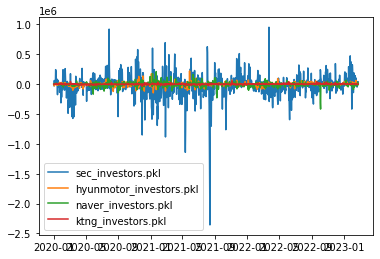

In [28]:
code = {'005930': ['삼성전자', 'sec'], '005380': ['현대차', 'hyunmotor'],
                 '035420': ['NAVER', 'naver'], '033780': ['KT&G', 'ktng']}
pkl_directory = 'data/company_pkl/'
for key, val in code.items():
    com_name = "/".join([key, val[0]])
    pkl_name= '{}_investors.pkl'.format(val[1])
    df_o = pd.read_pickle(pkl_directory + pkl_name)
    df_o = df_o[df_o['foreigner'] != '']
    plt.plot(df_o['date'], df_o['foreigner'], label=pkl_name)
    plt.legend()

In [29]:
df_o.tail()

,date,retail,foreigner,institution,financial,invtrust,pension,privequity,bank,insurance,financeetc,corporateetc,foreigneretc
1146,2023-02-20,-2755.0,924.0,1815.0,1803.0,30.0,-375.0,-59.0,25.0,384.0,7.0,-1.0,16.0
1147,2023-02-21,-1775.0,2448.0,-607.0,-2560.0,1130.0,-60.0,503.0,20.0,80.0,281.0,-58.0,-8.0
1148,2023-02-22,167.0,781.0,-948.0,-3749.0,1429.0,930.0,-32.0,-6.0,457.0,24.0,5.0,-4.0
1149,2023-02-23,-3209.0,108.0,2937.0,1655.0,1095.0,718.0,-375.0,5.0,-161.0,0.0,171.0,-7.0
1150,2023-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
pkl_name= 'sec_historical.pkl'
df_o = pd.read_pickle(pkl_directory + pkl_name)

In [31]:
df_o.tail(10)

,date,open,high,low,close,close_cr,vol
1141,2023-02-15,63900.0,63900.0,62000.0,62200.0,-1.58,826031.0
1142,2023-02-16,62500.0,63700.0,62400.0,63700.0,2.41,873760.0
1143,2023-02-17,62900.0,63300.0,62400.0,62600.0,-1.73,677810.0
1144,2023-02-18,,,,,,
1145,2023-02-19,,,,,,
1146,2023-02-20,62900,63000,61800,62700,0.16,806199
1147,2023-02-21,62700,62800,62000,62100,-0.96,476712
1148,2023-02-22,61500,61800,61000,61100,-1.61,732239
1149,2023-02-23,61700,62500,61500,62000,1.47,809465
1150,2023-02-24,62300,62600,62000,62200,0.32,188941
